<a href="https://colab.research.google.com/github/andygoosh/OneTwoTrip-Contest/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

Populating the interactive namespace from numpy and matplotlib
2.0.0
2.2.5


RandomState(MT19937) at 0x7F073B3E2678

In [0]:
df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid')
df_train

In [0]:
def prepare_data():

  X = df_train.copy()
  y = X[['goal1']]

  FTS = list(filter(lambda x: 'field' in x, df_train.columns))
  X = X[FTS]

  columns={'field11': 'hour1',
           'field23': 'hour2',
           'field2': 'month1',
           'field3': 'month2', 
           'field18': 'dow1',
           'field20': 'dow2'
  }

  X.rename(columns=columns, inplace=True)

  return X, y

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0728f42978>,
      dtype=object)

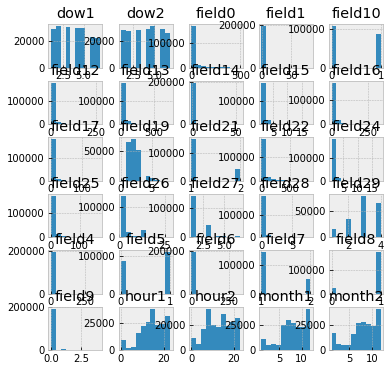

In [49]:
X, y = prepare_data()
X.hist()

In [72]:
X['field16'].describe()

count   196056.000000
mean        15.723854
std         25.689926
min          0.000000
25%          2.000000
50%          6.000000
75%         18.000000
max        340.000000
Name: field16, dtype: float64

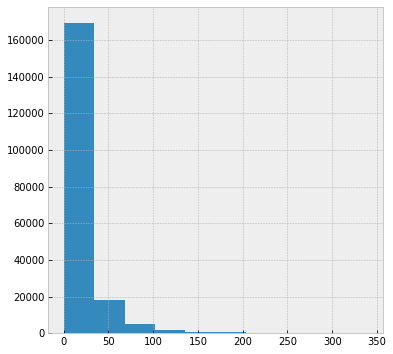

In [73]:
X['field16'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0728077b70>,
      dtype=object)

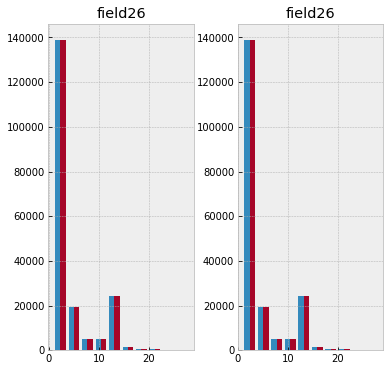

In [56]:
X[['field26','field26' ]].hist()

In [59]:
#corrs = X.corrwith(y).sort_values(ascending=False)
corrs = X.corrwith(y).nlargest(20)
corrs

Series([], dtype: float64)

In [0]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):
    print('.', end='')

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y.iloc[train_idx], y.iloc[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()
    model.fit(X_train, y_train)

    y_pred_cv = model.predict_proba(X_cv)
    y_hotted = pd.DataFrame(keras.utils.to_categorical(y_cv), index=y_cv.index)
    #y_hotted.drop([0, 7], axis=1, inplace=True)

    scores.append(skl.metrics.roc_auc_score(y_hotted, y_pred_cv))
    models.append(model)

  print('{:} CV: {:.4f} ± {:.4f}.'.format(type(model).__name__, np.mean(scores), np.std(scores)))
  return scores, models, neighbs, polies

In [76]:
from lightgbm import LGBMClassifier

X, y = prepare_data()

estimators = 340
params = {'boosting_type': 'gbdt', 
 'class_weight': 'balanced', 
 'colsample_bytree': 1.0, 
 'importance_type': 'split', 
 'learning_rate': 0.08, 
 'max_depth': -1, 
 'min_child_samples': 20, 
 'min_child_weight': 0.001, 
 'min_split_gain': 0.0, 
 'n_estimators': estimators, 
 'n_jobs': -1, 
 'num_leaves': 31, 
 'objective': None, 
 'random_state': 77, 
 'reg_alpha': 0.0, 
 'reg_lambda': 1.0, 
 'silent': True, 
 'subsample': 1.0, 
 'subsample_for_bin': 200000, 
 'subsample_freq': 0
 }

def_params = {'random_state': RS,
  'n_estimators': estimators,
}

scores, models, _, _ = fit_estimate(X, y, lambda: LGBMClassifier(**def_params), n_folds=5, n_neighbors=0)
lgbm = models[np.argmax(scores)]
#lgbm = LGBMClassifier(**def_params)
#scores = cross_val_score(lgbm, X, y, scoring='roc_auc', cv=5)

.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier CV: 0.6595 ± 0.0052.


field16    1007
field22     758
hour2       731
hour1       711
field1      677
           ... 
field25     293
field26     288
field19     235
field17     169
field10     112
Length: 20, dtype: int64

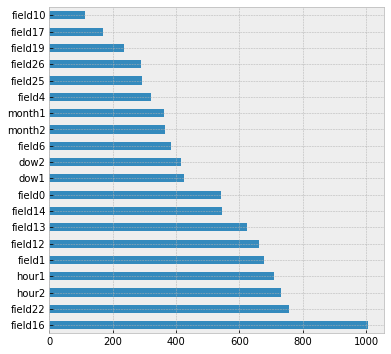

In [71]:
feat_importances = pd.Series(lgbm.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
feat_importances.nlargest(20)

In [0]:
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid')
FTS = list(filter(lambda x: 'field' in x, df_test.columns))
proba = lgbm.predict_proba(df_test[FTS])
pd.DataFrame(proba[:, 1], columns=['proba'], index=df_test.index).to_csv('sub1.csv')

In [68]:
!zip sub1.csv.zip sub1.csv

  adding: sub1.csv (deflated 58%)
